# Visual Odometryの推定
まずはじめに，テストサンプルの2組のRGBD画像データを読み込み，描画します．

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


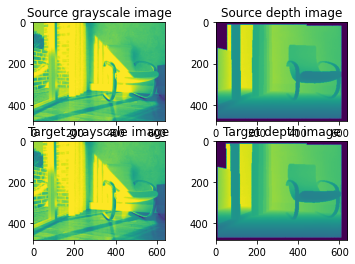

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

dirname = "../3rdparty/Open3D/examples/test_data/"

source_color = o3d.io.read_image(dirname + "/RGBD/color/00000.jpg")
source_depth = o3d.io.read_image(dirname + "/RGBD/depth/00000.png")
target_color = o3d.io.read_image(dirname + "/RGBD/color/00001.jpg")
target_depth = o3d.io.read_image(dirname + "/RGBD/depth/00001.png")
source_rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(source_color, source_depth)
target_rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(target_color, target_depth)

plt.subplot(2, 2, 1)
plt.title("Source grayscale image")
plt.imshow(source_rgbd.color)
plt.subplot(2, 2, 2)
plt.title("Source depth image")
plt.imshow(source_rgbd.depth)
plt.subplot(2, 2, 3)
plt.title("Target grayscale image")
plt.imshow(target_rgbd.color)
plt.subplot(2, 2, 4)
plt.title("Target depth image")
plt.imshow(target_rgbd.depth)
plt.show()

今回は，ソースRGBD画像（上図）をターゲットRGBD画像（下図）に移動させるようなカメラの動き（オドメトリ）を推定します．
このために，まずはカメラの内部パラメータ行列をファイルから取得します．

In [2]:
pinhole_camera_intrinsic = o3d.io.read_pinhole_camera_intrinsic(
    dirname + "/camera_primesense.json")
print(pinhole_camera_intrinsic.intrinsic_matrix)

[[525.    0.  319.5]
 [  0.  525.  239.5]
 [  0.    0.    1. ]]


そして，下記を実行します．

In [3]:
option = o3d.pipelines.odometry.OdometryOption()
odo_init = np.identity(4)
print(option)
[success_term, trans_term, info] = o3d.pipelines.odometry.compute_rgbd_odometry(source_rgbd, target_rgbd, pinhole_camera_intrinsic, odo_init, o3d.pipelines.odometry.RGBDOdometryJacobianFromColorTerm(), option)

OdometryOption class.
iteration_number_per_pyramid_level = [ 20, 10, 5, ] 
max_depth_diff = 0.030000
min_depth = 0.000000
max_depth = 4.000000


上記の4行目の関数が，Open3Dに実装されているSteinbruckerらの手法です．
この手法は，（変換後の）2組の入力RGBD画像の輝度値の差を最小化することでオドメトリを推定します．
Open3Dには，この手法の他に，（輝度値の差だけでなく）幾何的な制約を考慮するParkらの手法も実装されており，
上記の関数の5つ目の引数```o3d.pipelines.odometry.RGBDOdometryJacobianFromColorTerm()```を
```o3d.pipelines.odometry.RGBDOdometryJacobianFromHybridTerm()```に代えることで，
後者の手法を実行することが可能です．

さて，最後にオドメトリ推定結果の確認のため点群データを表示させましょう．

In [4]:
if not success_term:
    exit()
source_pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    source_rgbd, pinhole_camera_intrinsic)
target_pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    target_rgbd, pinhole_camera_intrinsic)
print("Using RGB-D Odometry")
print(trans_term)
source_pcd.transform(trans_term)
o3d.visualization.draw_geometries([target_pcd, source_pcd],
                                  zoom=0.48,
                                  front=[0.0999, -0.1787, -0.9788],
                                  lookat=[0.0345, -0.0937, 1.8033],
                                  up=[-0.0067, -0.9838, 0.1790])

Using RGB-D Odometry
[[ 9.99988286e-01 -7.53983409e-05 -4.83963172e-03  2.74054550e-04]
 [ 1.83909052e-05  9.99930634e-01 -1.17782559e-02  2.29634918e-02]
 [ 4.84018408e-03  1.17780289e-02  9.99918922e-01  6.02121265e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


上記の9行目の関数で，推定したオドメトリを用いてソースRGBD画像の点群データを幾何変換しています．
こうして，ソース点群データとターゲット点群データの二つの点群データが綺麗に重なっていることを確認することができます．

なお，研究用のRGBD画像ベンチマークデータセットは様々なものが存在しますが，
データセットによってDepth画像のフォーマットが異なります．
Open3Dでは，NYU，SUN，TUM，RedwoodデータセットのRGBD画像を読み込む関数がそれぞれ実装されています．